In [4]:
import pandas as pd
import numpy as np
import json
import pickle
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy import stats
import sys

from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
# https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html

from IPython.display import display_html
import sys

In [5]:
shared_path = 'C:/Users/Jonas/git/thesis/code/shared'
if shared_path not in sys.path:
    sys.path.append(shared_path)

mmd_path = 'C:/Users/Jonas/git/thesis/code/mmd'
if mmd_path not in sys.path:
    sys.path.append(mmd_path)

from Argument import Argument
from FeaturedArgument import FeaturedArgument
from MMDBase import MMDBase
from Inference import Inference
from Trainer import Trainer
from DataHandler import DataHandler

In [6]:
CLR_RESULTS = 'C:/Users/Jonas/git/thesis/code/evaluation/clr-context-level-results.csv'
SUPMMD_RESULTS = 'C:/Users/Jonas/git/thesis/code/evaluation/supmmd-context-level-results.csv'

In [7]:
clr_results = pd.read_csv(CLR_RESULTS)[1:]
clr_results

,d_1,d_2,d_3,avg_edge_corr,avg_silhouette_coef,would_you_like_to_live_in_the_world_of_harry_potter_edge_corr,would_you_like_to_live_in_the_world_of_harry_potter_silhouette_coef,because_edge_corr,because_silhouette_coef,messi_edge_corr,...,earth_is_flat_as_a_pizza_soc,colonizing_mars_argumentativeness,colonizing_mars_degree_centrality,colonizing_mars_soc,argument_argumentativeness,argument_degree_centrality,argument_soc,avg_argumentativeness,avg_degree_centrality,avg_soc
1,0.8,0.9,0.7,0.297291,0.052845,0.293301,0.03437,0.272316,0.096157,0.252635,...,0.335256,0.611835,0.310528,0.421981,0.617595,0.704921,0.642418,0.624813,0.592285,0.581716


In [8]:
def mean_x(x, df, insert):
    x_cols = list(filter(lambda c: c.endswith(x), df.columns))
    sub_df = df[x_cols]
    mean = sub_df.iloc[0].mean()
    df.insert(loc = insert,
              column = f'avg_{x}',
              value = [mean])

In [9]:
supmmd_results = pd.read_csv(SUPMMD_RESULTS)[1:]
mean_x('normalized_weighted_degree_centrality', supmmd_results, 4)
mean_x('soc', supmmd_results, 4)
mean_x('argumentativeness', supmmd_results, 4)
supmmd_results

,gamma,lambda,avg_edge_corr,avg_silhouette_coef,avg_argumentativeness,avg_soc,avg_normalized_weighted_degree_centrality,urbanization_edge_corr,urbanization_silhouette_coef,parenting_styles_child_development_edge_corr,...,wuhan_virus_soc,xbox_argumentativeness,xbox_normalized_weighted_degree_centrality,xbox_soc,xbox_series_argumentativeness,xbox_series_normalized_weighted_degree_centrality,xbox_series_soc,zoos_argumentativeness,zoos_normalized_weighted_degree_centrality,zoos_soc
1,2.0,0.875,0.25194,0.043299,0.640298,0.733804,0.741911,0.457492,0.132784,0.293565,...,0.83239,0.633935,1.137358,0.855957,0.631221,0.817243,0.77662,0.657525,0.715271,0.738807


In [10]:
records = [
    {
        'model': 'clr',
        'edge_correlation': clr_results['avg_edge_corr'].iloc[0],
        'silhouette_coefficient': clr_results['avg_silhouette_coef'].iloc[0],
        'argumentativeness': clr_results['avg_argumentativeness'].iloc[0],
        'degree_centralitiy': clr_results['avg_degree_centrality'].iloc[0],
        'soc': clr_results['avg_soc'].iloc[0]
    },
    {
        'model': 'supmmd',
        'edge_correlation': supmmd_results['avg_edge_corr'].iloc[0],
        'silhouette_coefficient': supmmd_results['avg_silhouette_coef'].iloc[0],
        'argumentativeness': supmmd_results['avg_argumentativeness'].iloc[0],
        'degree_centralitiy': supmmd_results['avg_normalized_weighted_degree_centrality'].iloc[0],
        'soc': supmmd_results['avg_soc'].iloc[0]
    },
]
df = pd.DataFrame.from_records(records)

In [11]:
df

,model,edge_correlation,silhouette_coefficient,argumentativeness,degree_centralitiy,soc
0,clr,0.297291,0.052845,0.624813,0.592285,0.581716
1,supmmd,0.251940,0.043299,0.640298,0.741911,0.733804


In [15]:
print(df.iloc[:, :-2].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
 model &  edge\_correlation &  silhouette\_coefficient &  argumentativeness \\
\midrule
   clr &          0.297291 &                0.052845 &           0.624813 \\
supmmd &          0.251940 &                0.043299 &           0.640298 \\
\bottomrule
\end{tabular}



In [12]:
def test(measure, threshold=.05):
    clr_cols = list(filter(lambda c: c.endswith(measure) and not c.startswith('avg'), clr_results.columns))
    supmmd_cols = list(filter(lambda c: c.endswith(measure) and not c.startswith('avg'), supmmd_results.columns))
    
    # normal distribution
    print(f'Nullhypothesis: CLR-{measure} sample is normally distributed. Performing Shapiro-Wilk test.')
    clr_sample = clr_results[clr_cols].iloc[0].values
    print(len(clr_sample))
    clr_shapiro = stats.shapiro(clr_sample)
    print(f'\t{clr_shapiro}')
    if clr_shapiro.pvalue < threshold:
        print(f'\tp-value is smaller than {threshold}, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.')
        clr_normal = False
    else:
        print('\tWe cannot reject the nullhypothesis and therefore assume the data is normally distributed.')
        clr_normal = True
        
    print(f'Nullhypothesis: SUPMMD-{measure} sample is normally distributed. Performing Shapiro-Wilk test.')
    supmmd_sample = supmmd_results[supmmd_cols].iloc[0].values
    supmmd_shapiro = stats.shapiro(supmmd_sample)
    print(f'\t{supmmd_shapiro}')
    if supmmd_shapiro.pvalue < threshold:
        print(f'\tp-value is smaller than {threshold}, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.')
        supmmd_normal = False
    else:
        print('\tWe cannot reject the nullhypothesis and therefore assume the data is normally distributed.')
        supmmd_normal = True
        
    # test difference
    if clr_normal and supmmd_normal:
        print('NotImplemented')
    else:
        print('Nullhypothesis: Median of differences is zero; Alt-Hypothesis: Median of differneces is not zero.')
        results = stats.wilcoxon(clr_sample, supmmd_sample, alternative='two-sided')
        print(f'\t{results}')
        if results.pvalue < threshold:
            print(f'\tp-value is smaller than {threshold}, thus, we have to reject the nullhypothesis and assume there is a significant difference.')
            print(f'\tmeans: clr-{measure} {np.median(clr_sample)}, supmmd-{measure} {np.median(supmmd_sample)}\n')
            return True
        else:
            print(f'\tWe cannot reject the nullhypothesis and therefore assume ther is no signigicant difference.')
            print(f'\tmeans: clr-{measure} {np.median(clr_sample)}, supmmd-{measure} {np.median(supmmd_sample)}\n')
            return False

In [17]:
test('edge_corr')

Nullhypothesis: CLR-edge_corr sample is normally distributed. Performing Shapiro-Wilk test.
469
	ShapiroResult(statistic=0.9627195000648499, pvalue=1.5744869852341026e-09)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.
Nullhypothesis: SUPMMD-edge_corr sample is normally distributed. Performing Shapiro-Wilk test.
	ShapiroResult(statistic=0.9558092951774597, pvalue=1.2162026941098247e-10)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.
Nullhypothesis: Median of differences is zero; Alt-Hypothesis: Median of differneces is not zero.
	WilcoxonResult(statistic=23555.0, pvalue=6.3154587405405856e-27)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume there is a significant difference.
	means: clr-edge_corr 0.2863647928370369, supmmd-edge_corr 0.2450067512675922



True

In [37]:
test('silhouette_coef')

Nullhypothesis: CLR-silhouette_coef sample is normally distributed. Performing Shapiro-Wilk test.
	ShapiroResult(statistic=0.9031959176063538, pvalue=1.0985877036056386e-16)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.
Nullhypothesis: SUPMMD-silhouette_coef sample is normally distributed. Performing Shapiro-Wilk test.
	ShapiroResult(statistic=0.9366644620895386, pvalue=3.1474885089748106e-13)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.
Nullhypothesis: Median of differences is zero; Alt-Hypothesis: Median of differneces is not zero.
	WilcoxonResult(statistic=41408.0, pvalue=3.0876953217944584e-06)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume there is a significant difference.
	means: clr-silhouette_coef 0.04814030975103378, supmmd-silhouette_coef 0.039540767669677734



True

In [13]:
test('argumentativeness')

Nullhypothesis: CLR-argumentativeness sample is normally distributed. Performing Shapiro-Wilk test.
466
	ShapiroResult(statistic=0.960915207862854, pvalue=8.649387317483104e-10)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.
Nullhypothesis: SUPMMD-argumentativeness sample is normally distributed. Performing Shapiro-Wilk test.
	ShapiroResult(statistic=0.9872132539749146, pvalue=0.0004128992441110313)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.
Nullhypothesis: Median of differences is zero; Alt-Hypothesis: Median of differneces is not zero.
	WilcoxonResult(statistic=27835.0, pvalue=6.534862226541666e-20)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume there is a significant difference.
	means: clr-argumentativeness 0.6226257724421365, supmmd-argumentativeness 0.6395443316016878



True

In [48]:
test('degree_centrality')

Nullhypothesis: CLR-degree_centrality sample is normally distributed. Performing Shapiro-Wilk test.
	ShapiroResult(statistic=0.9886589050292969, pvalue=0.0011196475243195891)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.
Nullhypothesis: SUPMMD-degree_centrality sample is normally distributed. Performing Shapiro-Wilk test.
	ShapiroResult(statistic=0.9947377443313599, pvalue=0.11189080029726028)
	We cannot reject the nullhypothesis and therefore assume the data is normally distributed.
Nullhypothesis: Median of differences is zero; Alt-Hypothesis: Median of differneces is not zero.
	WilcoxonResult(statistic=27724.0, pvalue=4.5893136801715095e-20)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume there is a significant difference.
	means: clr-degree_centrality 0.6000113553612569, supmmd-degree_centrality 0.736553494731448



True

In [49]:
test('soc')

Nullhypothesis: CLR-soc sample is normally distributed. Performing Shapiro-Wilk test.
	ShapiroResult(statistic=0.989068865776062, pvalue=0.0014973264187574387)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.
Nullhypothesis: SUPMMD-soc sample is normally distributed. Performing Shapiro-Wilk test.
	ShapiroResult(statistic=0.9810604453086853, pvalue=9.123237759922631e-06)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume our data is not normally distributed.
Nullhypothesis: Median of differences is zero; Alt-Hypothesis: Median of differneces is not zero.
	WilcoxonResult(statistic=15159.0, pvalue=1.7153768662778463e-41)
	p-value is smaller than 0.05, thus, we have to reject the nullhypothesis and assume there is a significant difference.
	means: clr-soc 0.5991484081106526, supmmd-soc 0.7390324546231164



True

The CLR achieves significantly larger scores in the contrastiveness dimensions (edge, silhouette). In contrast, SupMMD's results show significantly larger values for representativeness and argumentativeness.

In [14]:
clr_data = DataHandler()
clr_data.load_bin('C:/Users/Jonas/git/thesis/code/contra-lexrank/results/1632239915.4824035-3756-arguments-cleaned-test-w-excerpts.pickle')
clr_data.validate()

True

In [15]:
with open('C:/Users/Jonas/git/thesis/code/mmd/results/GW Eval-test 2021-10-24/test-data-with-excerpts.pickle', 'rb') as f:
    _args = pickle.load(f)
supmmd_data = DataHandler(_args)
supmmd_data.validate()

True

In [16]:
with open('C:/Users/Jonas/git/thesis/code/contra-lexrank/results/GW 2021-10-05 Test/arg_contexts.json', 'r') as file:
    arg_contexts = json.load(file)

In [17]:
clr_arg_contexts = {k: [] for k in DataHandler.get_query_context_keys(clr_data.get_arguments())}

for k in clr_arg_contexts.keys():
    clr_arg_contexts[k] = DataHandler.get_query_context(clr_data.get_arguments(), k)

In [18]:
supmmd_arg_contexts = {k: [] for k in DataHandler.get_query_context_keys(supmmd_data.get_arguments())}

for k in supmmd_arg_contexts.keys():
    supmmd_arg_contexts[k] = DataHandler.get_query_context(supmmd_data.get_arguments(), k)

In [19]:
records = list()
for k in clr_arg_contexts.keys():
    a = [len(b.sentences) for b in clr_arg_contexts[k]]
    #print(a)
    records.append({
        'context': k,
        'len': len(clr_arg_contexts[k]),
        'arg_lengths': a,
        'mean_arg_length':  np.mean(a),
        'std_arg_length':  np.std(a),
        'median_arg_length': np.median(a),
        'max_arg_length': np.max(a),
    })
context_sizes = pd.DataFrame.from_records(records)

In [20]:
context_sizes.sort_values(by=['len'], ascending=True)[:20]

,context,len,arg_lengths,mean_arg_length,std_arg_length,median_arg_length,max_arg_length
264,veganism_is_healthy,3,"[11, 14, 27]",17.333333,6.944222,14.0,27
151,radio,3,"[5, 10, 15]",10.000000,4.082483,10.0,15
187,star_wars,3,"[3, 14, 10]",9.000000,4.546061,10.0,14
81,nuclear_energy_should_be_banned,3,"[73, 76, 82]",77.000000,3.741657,76.0,82
92,climate_change,3,"[11, 35, 11]",19.000000,11.313708,11.0,35
418,arduino,3,"[6, 8, 3]",5.666667,2.054805,6.0,8
374,transnational_governance,3,"[14, 6, 7]",9.000000,3.559026,7.0,14
459,elon_musk,3,"[6, 3, 8]",5.666667,2.054805,6.0,8
99,pokemon,3,"[4, 9, 13]",8.666667,3.681787,9.0,13
271,heart,3,"[10, 3, 4]",5.666667,3.091206,4.0,10


In [21]:
context_sizes\
    [\
     (context_sizes.len <= 5) &\
     (context_sizes.max_arg_length <= 15)]\
    .sort_values(by=['len'], ascending=True)

,context,len,arg_lengths,mean_arg_length,std_arg_length,median_arg_length,max_arg_length
45,urbanization,3,"[3, 9, 8]",6.666667,2.624669,8.0,9
418,arduino,3,"[6, 8, 3]",5.666667,2.054805,6.0,8
412,religion,3,"[4, 4, 4]",4.000000,0.000000,4.0,4
374,transnational_governance,3,"[14, 6, 7]",9.000000,3.559026,7.0,14
271,heart,3,"[10, 3, 4]",5.666667,3.091206,4.0,10
200,law,3,"[9, 7, 4]",6.666667,2.054805,7.0,9
187,star_wars,3,"[3, 14, 10]",9.000000,4.546061,10.0,14
459,elon_musk,3,"[6, 3, 8]",5.666667,2.054805,6.0,8
151,radio,3,"[5, 10, 15]",10.000000,4.082483,10.0,15
141,merkel,3,"[6, 4, 4]",4.666667,0.942809,4.0,6


In [22]:
def print_arg(arg, hl=None):
    html_str = f'<p style="text-align:right">{arg.arg_id}</p><div style="border: solid black 1px; padding-left: 5px">'
    for idx, s in enumerate(arg.sentences):
        if hl is None:
            html_str += f'<span style="color:grey">{idx+1:02d} </span><span style="width:50%; background-color:{"yellow" if s in arg.snippet else "white"}">{s}</span><br>'
        else:
            html_str += f'<span style="color:grey">{idx+1:02d} </span><span style="width:50%; background-color:{"yellow" if idx in hl else "white"}">{s}</span><br>'
    #display_html(html_str+ '</div>', raw=True)
    return html_str+ '</div>'
    
def print_context(context):
    html_str = f"""<table><tr><th style="text-align: center;">clr</th><th style="text-align: center;">supmmd</th></tr>"""
    sa = supmmd_arg_contexts[context]
    ca = clr_arg_contexts[context]
    
    for a in sa:
        x = [arg for arg in ca if arg.arg_id == a.arg_id][0]
        html_str += f"""
            <tr>
                <td style="text-align: left;">{print_arg(x, x.excerpt_indices)}</td>
                <td style="text-align: left;">{print_arg(a, a.excerpt_indices)}</td>
            </tr
        """
    display_html(html_str+'</table>', raw=True)

In [23]:
print_context('heart')

clr,supmmd
"Sf0d01479-Abc2109c301 Greetings Internet, Before I address the issue of abortion you first must address and define life.02 Life:the quality that distinguishes a vital and functional being from a dead body.03 Being dead, lack of a heart beat.04 Six to eight weeks the child inside its mother has a heart beat.05 To extinguish the heart beat intentionally as in abortion should fall under the same category as murder both morally and judicially.06 A popular question the other side likes to discuss is What if the mother is raped Or Incest.07 Once that child has a heartbeat it should be aloud the same rights as an other US citizen.08 Is it not the child's fault the mother was raped?09 I am not by any means taking away from the horrible nature of a woman being raped.10 But by committing another violent act to cover up another will not take the rape away and will not close the mental wounds inflicted on the woman.","Sf0d01479-Abc2109c301 Greetings Internet, Before I address the issue of abortion you first must address and define life.02 Life:the quality that distinguishes a vital and functional being from a dead body.03 Being dead, lack of a heart beat.04 Six to eight weeks the child inside its mother has a heart beat.05 To extinguish the heart beat intentionally as in abortion should fall under the same category as murder both morally and judicially.06 A popular question the other side likes to discuss is What if the mother is raped Or Incest.07 Once that child has a heartbeat it should be aloud the same rights as an other US citizen.08 Is it not the child's fault the mother was raped?09 I am not by any means taking away from the horrible nature of a woman being raped.10 But by committing another violent act to cover up another will not take the rape away and will not close the mental wounds inflicted on the woman."
S27a82f4b-Ae4ab809501 They hurt really bad.02 I'm not sure what that blob of text you just wrote is.03 Heart attacks are bad and thats final.,S27a82f4b-Ae4ab809501 They hurt really bad.02 I'm not sure what that blob of text you just wrote is.03 Heart attacks are bad and thats final.
"S27a82f4b-A5d84e87401 I have shown that heart attacks are deadly.02 Maybe they don't always kill you but they are bad for you.03 Always.04 Also, it would be nice if Pro provided a source.","S27a82f4b-A5d84e87401 I have shown that heart attacks are deadly.02 Maybe they don't always kill you but they are bad for you.03 Always.04 Also, it would be nice if Pro provided a source."


How often do the approaches agree on the snippet?

In [24]:
ids = set([a.arg_id for a in supmmd_data.get_arguments()])
len(ids)

3297

In [25]:
all_equal = list()
any_equal = list()
none_equal = list()
for id in ids:
    sm = [a for a in supmmd_data.get_arguments() if a.arg_id == id][0]
    cm = [a for a in clr_data.get_arguments() if a.arg_id == id][0]
    if (sm.excerpt_indices[0] == cm.excerpt_indices[0]) and (sm.excerpt_indices[1] == cm.excerpt_indices[1]):
        all_equal.append(id)
    elif (sm.excerpt_indices[0] == cm.excerpt_indices[0]) or (sm.excerpt_indices[1] == cm.excerpt_indices[1]):
        any_equal.append(id)
    else:
        none_equal.append(id)

In [31]:
len(all_equal), len(all_equal)/len(ids)

(76, 0.02305125872004853)

In [32]:
len(any_equal), len(any_equal)/len(ids)

(551, 0.16712162572035183)

In [33]:
len(none_equal), len(none_equal)/len(ids)

(2670, 0.8098271155595996)

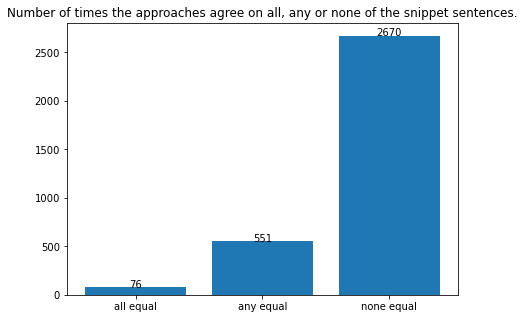

In [30]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

objects = ('all equal', 'any equal', 'none equal')
y_pos = np.arange(len(objects))
performance = [len(all_equal), len(any_equal), len(none_equal)]
plt.figure(figsize=(7,5))
plt.bar(y_pos, performance, align='center', alpha=1.)

addlabels(objects, performance)
plt.xticks(y_pos, objects)
plt.ylabel('')
plt.title('Number of times the approaches agree on all, any or none of the snippet sentences.')

plt.show()